# <!-- TITLE --> Projet 6 : notebook 2
<!-- AUTHOR : Anthony DAVID -->

In [1]:
import os, time, sys, pathlib, json, glob
import math, random
import datetime
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import sklearn.metrics

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from IPython.display import display,Image,Markdown,HTML

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# 2 - First convolutions

## 2.1 - Parameters
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [3]:
enhanced_dir = './data'

dataset_name  = 'set-RGB'
batch_size    = 10
epochs        = 20
fit_verbosity = 1

In [4]:
import os

# Dossier de destination contenant les images copiées
destination_dir = './selected_data/images/'

# Vérifier si le dossier de destination existe et récupérer les noms des classes
if os.path.exists(destination_dir):
    class_names = [breed_dir for breed_dir in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, breed_dir))]
else:
    class_names = []

# Nombre de classes
num_classes = len(class_names)

# Affichage
print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['Rottweiler', 'Doberman', 'Weimaraner', 'Staff', 'Malinois']
Number of classes: 5


## 2.2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-RGB

In [5]:
# a function to shuffle the dataset

def shuffle_np_dataset(*data):
    """
    Shuffle a list of dataset
    args:
        *data : datasets
    return:
        *datasets mixed
    """
    p = np.random.permutation(len(data[0]))
    out = [d[p] for d in data]
    return out[0] if len(out) == 1 else out

# a function to read the dataset

def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset including train, val, and test splits
    Args:
        enhanced_dir : directory where datasets are saved
        dataset_name : dataset name, without .h5
    Returns:    x_train, y_train, x_val, y_val, x_test, y_test data'''
    # ---- Read dataset
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with h5py.File(filename, 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_val = f['x_val'][:]
        y_val = f['y_val'][:]
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle train data only
    x_train, y_train = shuffle_np_dataset(x_train, y_train)

    print(f'Dataset "{dataset_name}" is loaded and shuffled.')
    return x_train, y_train, x_val, y_val, x_test, y_test


In [6]:
# Read dataset
x_train, y_train, x_val, y_val, x_test, y_test = read_dataset(enhanced_dir, dataset_name)

(604, 224, 224, 3) (604,)
Dataset "set-RGB" is loaded and shuffled.


## 2.3 - Have a look to the dataset


x_train: (604, 224, 224, 3)
y_train: (604,)
x_val  : (172, 224, 224, 3)
y_val  : (172,)
x_test : (77, 224, 224, 3)
y_test : (77,)


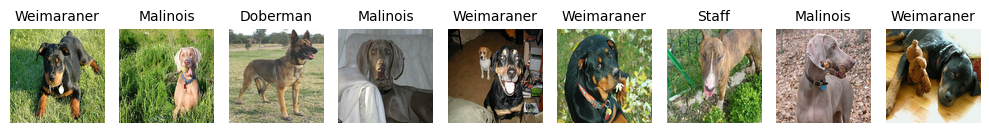

In [7]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val  :", x_val.shape)
print("y_val  :", y_val.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)

n_figs = 9
fig, axes = plt.subplots(1, n_figs, figsize=(10, 10))
y_train_strings = [class_names[label] for label in y_train]

for i in range(n_figs):
    image = x_train[i]
    name = y_train_strings[i]
    ax = axes[i % n_figs]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2.4 - Create model
We will now build a model and train it. We will compare different models latter.

In [8]:
def first_model(lx,ly,lz):
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model

## 2.5 - Train the model

**Get the shape of my data :**

In [9]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (224, 224, 3)


**Get and compile a model, with the data shape :**

In [10]:
model = first_model(lx,ly,lz)

model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

/Users/anthonydavid/Workspace/Openclassrooms/projet_6/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1152)           │    42,468,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,862,661 (163.51 MB)

 Trainable params: 42,862,661 (163.51 MB)

 Non-trainable params: 0 (0.00 B)

**Train it :**

As we need integer labels for y we convert the strings to integers.

In [11]:
# ---- Shuffle train data
x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_val, y_val))


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 354ms/step - accuracy: 0.1776 - loss: 1.7521 - val_accuracy: 0.2558 - val_loss: 1.6034
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.2589 - loss: 1.5497 - val_accuracy: 0.2616 - val_loss: 1.5926
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - accuracy: 0.3922 - loss: 1.4710 - val_accuracy: 0.2500 - val_loss: 1.5330
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.4463 - loss: 1.3698 - val_accuracy: 0.3488 - val_loss: 1.5162
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.4561 - loss: 1.3111 - val_accuracy: 0.3081 - val_loss: 1.5059
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.5155 - loss: 1.1707 - val_accuracy: 0.2907 - val_loss: 1.5090
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.6369 - loss: 0.9364 - val_accuracy: 0.3314 - val_loss: 1.5008
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.6843 - loss: 0.8652 - val_accu

## 2.6 - Evaluate

In [12]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.3605


In [13]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Val loss      : {:5.4f}'.format(score[0]))
print('Val accuracy  : {:5.4f}'.format(score[1]))

Val loss      : 3.5811
Val accuracy  : 0.3605


## 2.7 - Evaluate on Test Set

In [14]:
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:5.4f}'.format(test_score[0]))
print('Test accuracy: {:5.4f}'.format(test_score[1]))

Test loss: 3.7265
Test accuracy: 0.3377


# 3 - Tracking and Visualizing

## 3.1 - Parameters

In [15]:
batch_size    = 10
epochs        = 20
fit_verbosity = 1

## 3.2 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard). \
We can use Tensorboard by using the following : \
%load_ext tensorboard \
%tensorboard --logdir /path/to/logs

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [16]:
def tag_now():
    '''
    Return a string tag for current date/time
    args:
        nothing
    return:
        current formated date/time tag as '%Y-%m-%d_%Hh%Mm%Ss'
    '''
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [17]:
run_dir = './run_first_convolutions'
figs_dir = './figs_first_convolutions'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.keras"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.keras"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /Users/anthonydavid/Workspace/Openclassrooms/projet_6/run_first_convolutions/logs


## 3.3 - Train the model

**Get the shape of my data :**

In [18]:
# Obtenir la forme des données d'entraînement
(n, lx, ly, lz) = x_train.shape
print("Images of the dataset have this following shape:", (lx, ly, lz))

# Créer et compiler le modèle
model = first_model(lx, ly, lz)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Images of the dataset have this following shape: (224, 224, 3)


**Train it :**  
Note: The training curve is visible in real time with Tensorboard

In [19]:
# ---- Mélanger les données d'entraînement
x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Entraîner le modèle
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=fit_verbosity,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback])

# Sauvegarder le modèle final
model.save(f'{run_dir}/models/last-model.keras')


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 585ms/step - accuracy: 0.1986 - loss: 1.8134 - val_accuracy: 0.2558 - val_loss: 1.6025
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 549ms/step - accuracy: 0.3317 - loss: 1.5489 - val_accuracy: 0.2151 - val_loss: 1.5895
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 497ms/step - accuracy: 0.3420 - loss: 1.5059 - val_accuracy: 0.3023 - val_loss: 1.5394
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 525ms/step - accuracy: 0.4164 - loss: 1.3914 - val_accuracy: 0.2791 - val_loss: 1.5321
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 0.4760 - loss: 1.2831 - val_accuracy: 0.2791 - val_loss: 1.4981
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 34s 536ms/step - accuracy: 0.5570 - loss: 1.1714 - val_accuracy: 0.2791 - val_loss: 1.5209
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 527ms/step - accuracy: 0.5292 - loss: 1.1358 - val_accuracy: 0.2965 - val_loss: 1.5070
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.6152 - loss: 0.9916 - val_accu

**Evaluate it :**

In [20]:
# Évaluer le modèle sur l'ensemble de validation
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is: {:.4f}".format(max_val_accuracy))
val_score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss: {:5.4f}'.format(val_score[0]))
print('Validation accuracy: {:5.4f}'.format(val_score[1]))


Max validation accuracy is: 0.3314
Validation loss: 3.3764
Validation accuracy: 0.3081


In [21]:
# Évaluation finale sur l'ensemble de test
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:5.4f}'.format(test_score[0]))
print('Test accuracy: {:5.4f}'.format(test_score[1]))

Test loss: 3.5477
Test accuracy: 0.2468


## 3.4 - History
The return of model.fit() returns us the learning history

In [22]:
# # Load and use the TensorBoard notebook extension
# %load_ext tensorboard

In [23]:
# !tensorboard --logdir /Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/run/logs --port=8008

In [24]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig(figs_dir+'/'+figname+'.png')
        plt.show()


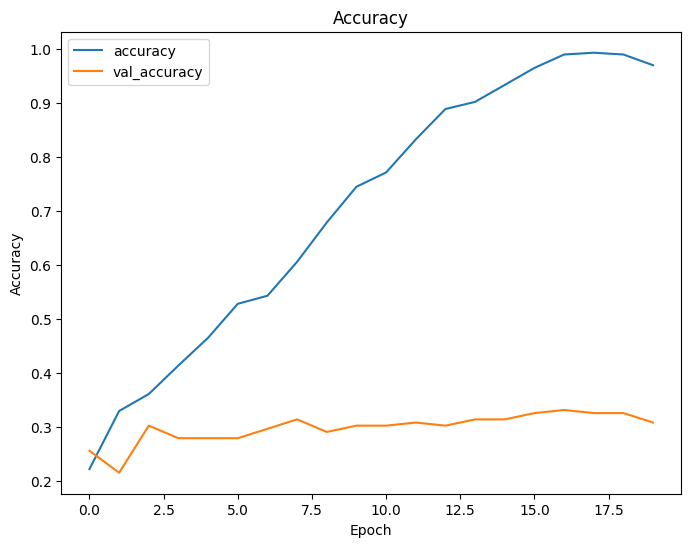

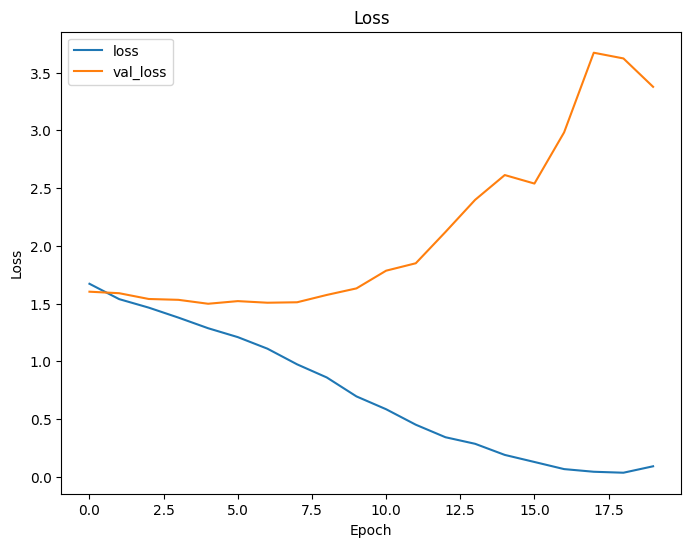

In [25]:
plot_history(history, save_as='history')

## 3.5 - Evaluation and confusion

In [26]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


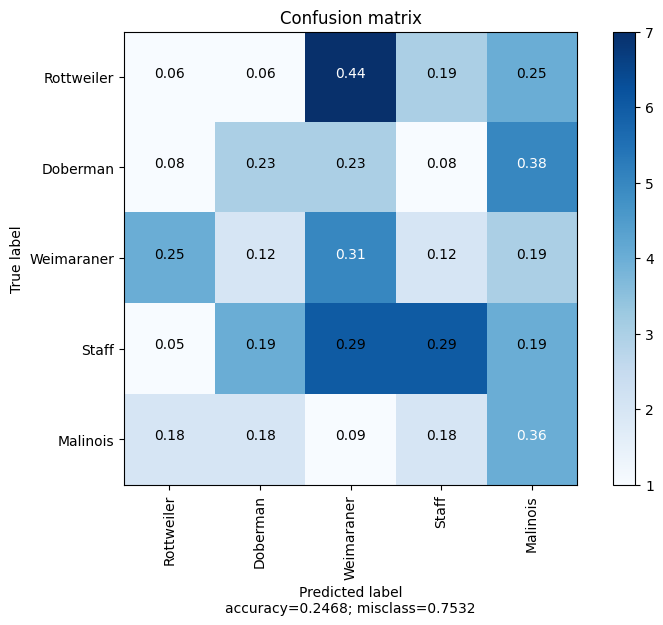

In [27]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

## 3.6 - Restore and evaluate

### 3.6.1 - List saved models :

In [28]:
!find "$run_dir"/models/

./run_first_convolutions/models/
./run_first_convolutions/models//model-0017.keras
./run_first_convolutions/models//.DS_Store
./run_first_convolutions/models//last-model.keras
./run_first_convolutions/models//model-0018.keras
./run_first_convolutions/models//best-model.keras
./run_first_convolutions/models//model-0020.keras
./run_first_convolutions/models//model-0019.keras


### 3.6.2 - Restore a model :

In [29]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.keras')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 3.6.3 - Evaluate it :

In [30]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 3.8209
Test accuracy  : 0.2987


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


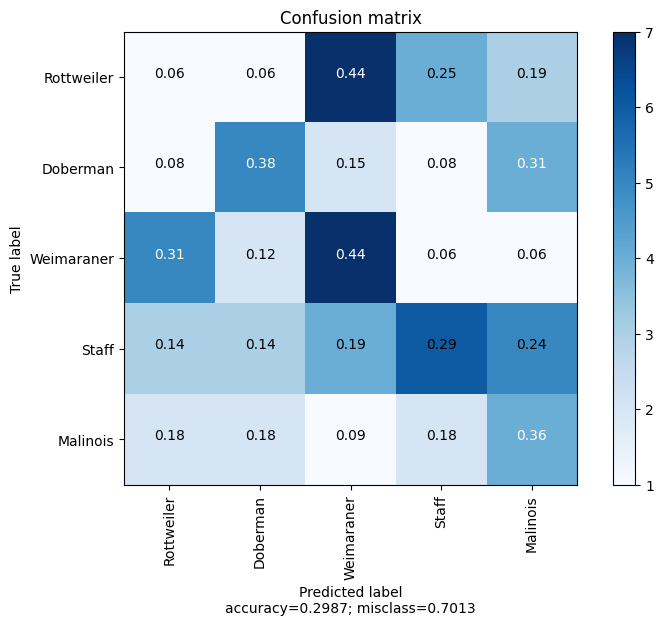

In [31]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

### 3.6.4 - Make a prediction :

In [32]:
# Define parameters for loading the dataset
# batch_size = 1  # One image per class
image_size = (224, 224)  # Size of images in the dataset
directory_path = './dataset_meta'

# Create the meta dataset using image_dataset_from_directory
meta_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    batch_size=num_classes,
    image_size=image_size,
    shuffle=False,  # No need to shuffle, as one image per class
)

# Print class names
meta_class_names = meta_dataset.class_names
print("Meta lass names:", meta_class_names)

x_meta = []
y_meta = []
for images, labels in meta_dataset:
    x_meta.append(images.numpy().astype("uint8"))
    y_meta.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_meta = tf.concat(x_meta, axis=0).numpy()
y_meta = tf.concat(y_meta, axis=0).numpy()

Found 5 files belonging to 5 classes.
Meta lass names: ['Doberman', 'Malinois', 'Rottweiler', 'Staff', 'Weimaraner']


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Output layer from model is (x100) :

[[ 0.01 51.4  48.48  0.1   0.  ]]

Graphically :



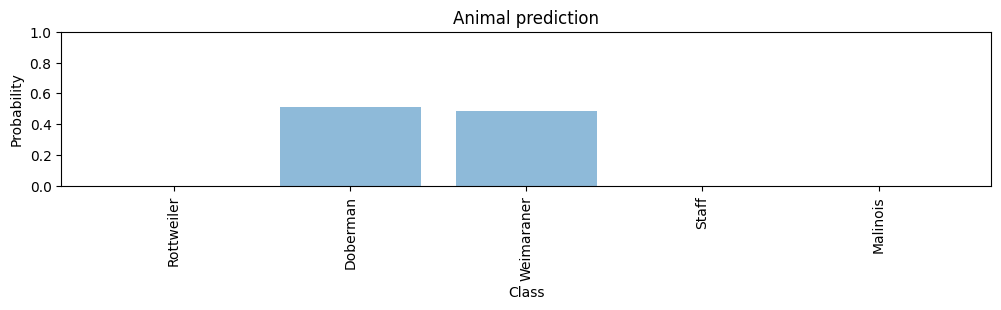


The image :                         Prediction :                      Real stuff:


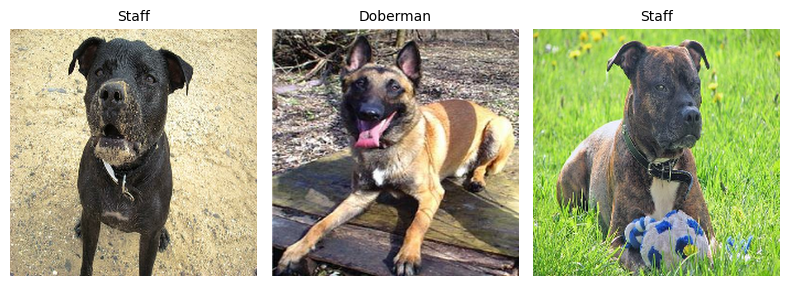

oups, that's wrong :(


In [33]:
# ---- Get a random image
#
i    = random.randint(1,len(x_test))
x, y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict(np.array([x]))

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(num_classes), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))

target_names = [class_names[label] for label in range(len(class_names))]
tick_marks = np.arange(len(target_names))

plt.xticks(tick_marks, target_names, rotation=90)
plt.xlabel('Class')
plt.title('Animal prediction')
plt.savefig(figs_dir+'/prediction-proba.png')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :                         Prediction :                      Real stuff:")

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(8, 6))
# fig.subplots_adjust(hspace=.5)
x_list = [x, x_meta[p], x_meta[y]]
y_list_strings = [class_names[label] for label in [y, p, y]]
# Generate and plot the images in a loop
for i in range(3):
    image = x_list[i]
    name = y_list_strings[i]
    
    # Get the current axis and plot the image
    ax = axes[i%n_figs]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.savefig(figs_dir+'/prediction-images.png')
plt.show()

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong :(")

# 3 - Tracking and Visualizing v2

## 3.1 - Parameters and secoond model

In [34]:
def second_model(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.RandomFlip('horizontal'))
    model.add( keras.layers.RandomRotation(0.2))
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model

In [35]:
batch_size    = 16
epochs        = 30
fit_verbosity = 1

## 3.2 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard). \
We can use Tensorboard by using the following : \
%load_ext tensorboard \
%tensorboard --logdir /path/to/logs

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [36]:
def tag_now():
    '''
    Return a string tag for current date/time
    args:
        nothing
    return:
        current formated date/time tag as '%Y-%m-%d_%Hh%Mm%Ss'
    '''
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [67]:
run_dir = './run_first_convolutions'
figs_dir = './figs_first_convolutions/v2'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model-2.keras"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.keras"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /Users/anthonydavid/Workspace/Openclassrooms/projet_6/run_first_convolutions/logs


## 3.3 - Train the model

**Get the shape of my data :**

In [38]:
# Obtenir la forme des données d'entraînement
(n, lx, ly, lz) = x_train.shape
print("Images of the dataset have this following shape:", (lx, ly, lz))

# Créer et compiler le modèle
model = second_model(lx, ly, lz)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Images of the dataset have this following shape: (224, 224, 3)


/Users/anthonydavid/Workspace/Openclassrooms/projet_6/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Train it :**  
Note: The training curve is visible in real time with Tensorboard

In [39]:
# ---- Mélanger les données d'entraînement
x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Entraîner le modèle
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=fit_verbosity,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback])

# Sauvegarder le modèle final
model.save(f'{run_dir}/models/last-model-2.keras')


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 855ms/step - accuracy: 0.2018 - loss: 1.6928 - val_accuracy: 0.2151 - val_loss: 1.6050
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 905ms/step - accuracy: 0.2920 - loss: 1.5573 - val_accuracy: 0.1977 - val_loss: 1.5891
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 809ms/step - accuracy: 0.2956 - loss: 1.5330 - val_accuracy: 0.1860 - val_loss: 1.5750
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3605 - loss: 1.4754 - val_accuracy: 0.3314 - val_loss: 1.5543
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 800ms/step - accuracy: 0.3297 - loss: 1.4711 - val_accuracy: 0.3256 - val_loss: 1.5499
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 767ms/step - accuracy: 0.3567 - loss: 1.4397 - val_accuracy: 0.3140 - val_loss: 1.5175
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 773ms/step - accuracy: 0.3679 - loss: 1.3981 - val_accuracy: 0.3372 - val_loss: 1.5021
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 750ms/step - accuracy: 0.3664 - loss: 1.3816 - val_accurac

**Evaluate it :**

In [54]:
# Évaluer le modèle sur l'ensemble de validation
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is: {:.4f}".format(max_val_accuracy))
val_score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss: {:5.4f}'.format(val_score[0]))
print('Validation accuracy: {:5.4f}'.format(val_score[1]))


Max validation accuracy is: 0.4128
Validation loss: 1.4251
Validation accuracy: 0.3953


In [55]:
# Évaluation finale sur l'ensemble de test
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:5.4f}'.format(test_score[0]))
print('Test accuracy: {:5.4f}'.format(test_score[1]))

Test loss: 1.4359
Test accuracy: 0.3766


## 3.4 - History
The return of model.fit() returns us the learning history

In [56]:
# # Load and use the TensorBoard notebook extension
# %load_ext tensorboard

In [57]:
# !tensorboard --logdir /Users/anthonydavid/Documents/Etudes/data_scientist/projets/CNN_animals/run/logs --port=8008

In [58]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig(figs_dir+'/'+figname+'.png')
        plt.show()


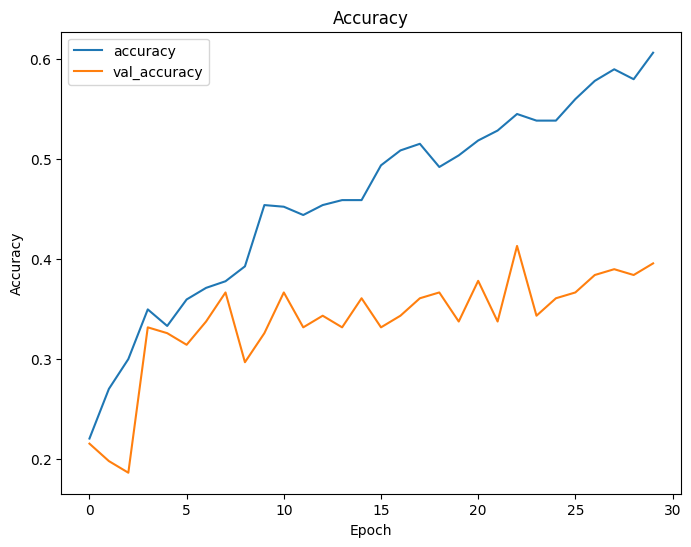

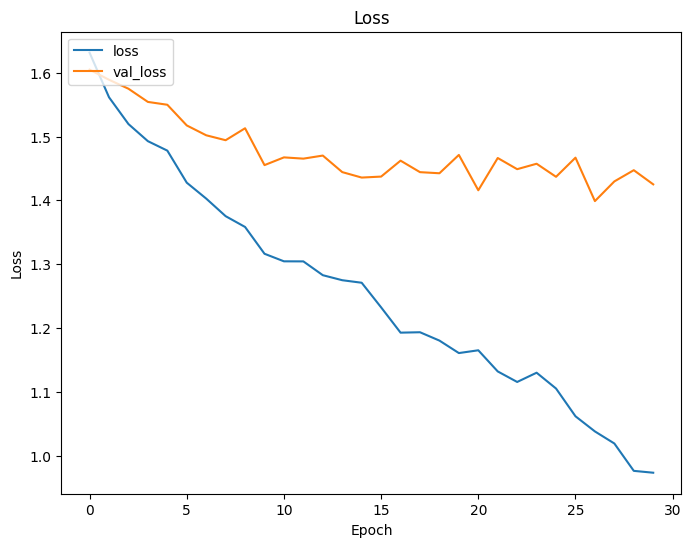

In [59]:
plot_history(history, save_as='history')

## 3.5 - Evaluation and confusion

In [60]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


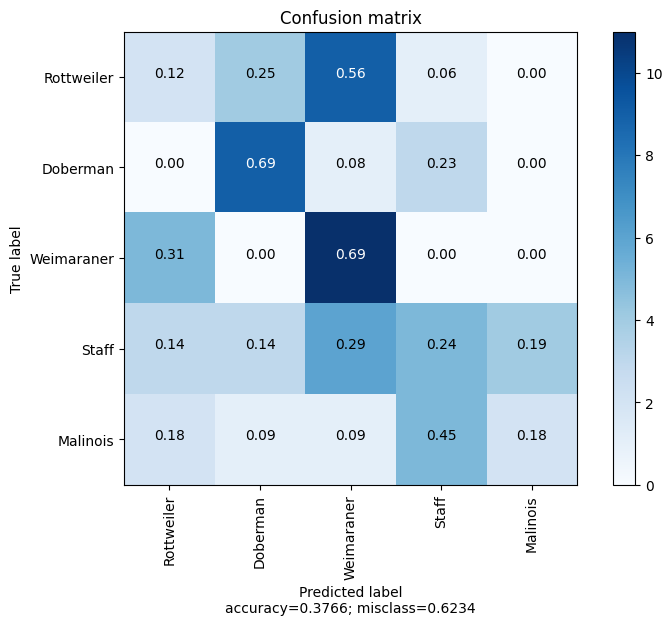

In [61]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

## 3.6 - Restore and evaluate

### 3.6.1 - List saved models :

In [68]:
!find "$run_dir"/models/

./run_first_convolutions/models/
./run_first_convolutions/models//last-model-2.keras
./run_first_convolutions/models//.DS_Store
./run_first_convolutions/models//last-model.keras
./run_first_convolutions/models//best-model.keras
./run_first_convolutions/models//best-model-2.keras


### 3.6.2 - Restore a model :

In [69]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model-2.keras')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 3.6.3 - Evaluate it :

In [70]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.4359
Test accuracy  : 0.3766


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


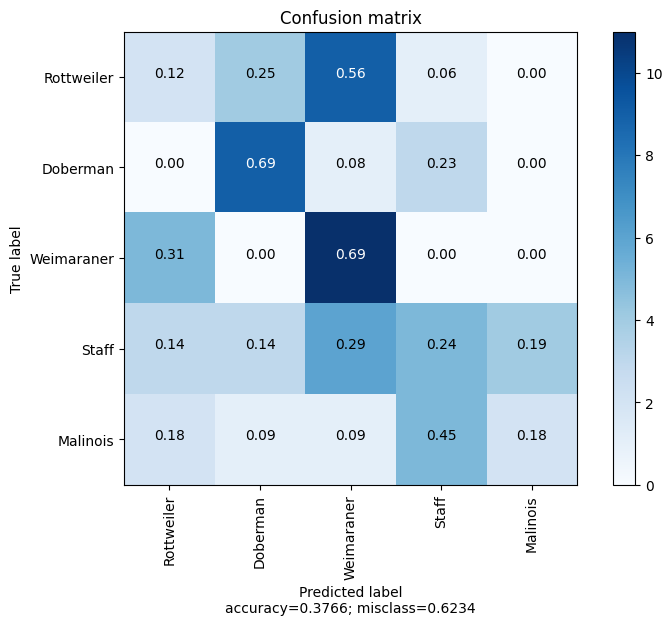

In [71]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

### 3.6.4 - Make a prediction :

In [72]:
# Define parameters for loading the dataset
# batch_size = 1  # One image per class
image_size = (224, 224)  # Size of images in the dataset
directory_path = './dataset_meta'

# Create the meta dataset using image_dataset_from_directory
meta_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    batch_size=num_classes,
    image_size=image_size,
    shuffle=False,  # No need to shuffle, as one image per class
)

# Print class names
meta_class_names = meta_dataset.class_names
print("Meta lass names:", meta_class_names)

x_meta = []
y_meta = []
for images, labels in meta_dataset:
    x_meta.append(images.numpy().astype("uint8"))
    y_meta.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_meta = tf.concat(x_meta, axis=0).numpy()
y_meta = tf.concat(y_meta, axis=0).numpy()

Found 5 files belonging to 5 classes.
Meta lass names: ['Doberman', 'Malinois', 'Rottweiler', 'Staff', 'Weimaraner']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

Output layer from model is (x100) :

[[ 9.81 19.73  4.38 29.3  36.78]]

Graphically :



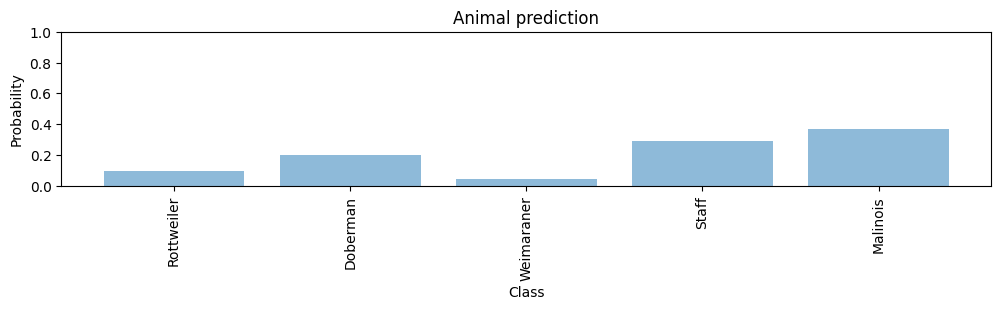


The image :                         Prediction :                      Real stuff:


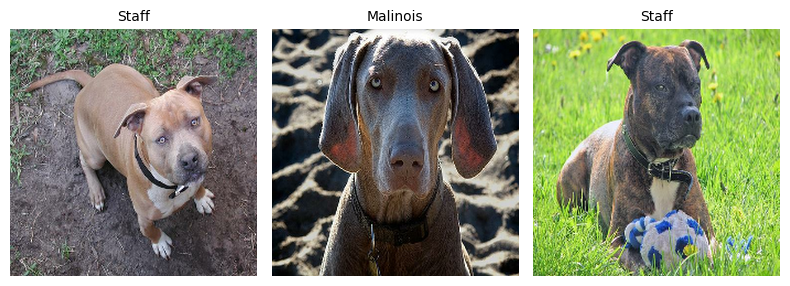

oups, that's wrong :(


In [73]:
# ---- Get a random image
#
i    = random.randint(1,len(x_test))
x, y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict(np.array([x]))

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(num_classes), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))

target_names = [class_names[label] for label in range(len(class_names))]
tick_marks = np.arange(len(target_names))

plt.xticks(tick_marks, target_names, rotation=90)
plt.xlabel('Class')
plt.title('Animal prediction')
plt.savefig(figs_dir+'/prediction-proba.png')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :                         Prediction :                      Real stuff:")


n_figs = 9

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(8, 6))
# fig.subplots_adjust(hspace=.5)
x_list = [x, x_meta[p], x_meta[y]]
y_list_strings = [class_names[label] for label in [y, p, y]]
# Generate and plot the images in a loop
for i in range(3):
    image = x_list[i]
    name = y_list_strings[i]
    
    # Get the current axis and plot the image
    ax = axes[i%n_figs]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.savefig(figs_dir+'/prediction-images.png')
plt.show()

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong :(")